# IE613-Birr analysis of initial land survey

The first order of business is to read the CSV file containing the ETRS89 measurements of the surface of the Birr station.

In [30]:
from numpy import *
from matplotlib.pyplot import *
from numpy.linalg.linalg import norm
%matplotlib inline
import csv, re
def s(arr):
    '''Shorthand for printing array (with round brackets)'''
    return array2string(arr,
                        separator=",",
                        precision=3.7).replace("[ ","(").replace("]",")")

In [31]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [32]:
with open('BIRR Survey Coordinates.csv', 'r') as csv_file:
    csv_rows = [(row[0],
                 array([float(num) for num in row[1:4]]),
                 row[4]
                )
                for row in csv.reader(csv_file, delimiter=',')
                if 'ETRS' not in row[1]]
print(len(csv_rows))
csv_rows[0:3]

250


[('P001', array([ 53.094608,  -7.92103 ,  98.418   ]), 'ARRAY BASE'),
 ('P002', array([ 53.094576,  -7.921042,  98.405   ]), 'ARRAY BASE'),
 ('P003', array([ 53.094547,  -7.921062,  98.487   ]), 'ARRAY BASE')]

### Convert survey coordinates to ETRS xyz

The site survey was provided in lat-long-height with respect to WGS84 ellipsoid; we need to transform this to xyz for the rest of the analysis.

We will use the external library `pyproj` for this, because the `lofargeo` package does not support it (and we don't want to write it ourselves). The `lofargeo` package does support the inverse transform *ECEF* to *lat-long-alt*. This means we can test the conversion of `pyproj` by checking that the operation is indeed the inverse.

In [33]:
import pyproj
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

In [34]:
import lofargeo

In [35]:
cs002latlonalt = array([52.5454074,06.5207900,49.347])

# Transform from LLA to ECEF using pyproj
# Note: pyproj wants long-lat
cs002ecef = pyproj.transform(lla,
                             ecef,
                             cs002latlonalt[1], # Longitude
                             cs002latlonalt[0], # Latitude
                             cs002latlonalt[2], # Altitude
                             radians=False)

# Transform back with lofargeo
cs002latlonalt_lofargeo = lofargeo.geographic_from_xyz(array(cs002ecef))

# Print difference
print(array(
    [rad2deg(cs002latlonalt_lofargeo['lat_rad']),
     rad2deg(cs002latlonalt_lofargeo['lon_rad']),
     cs002latlonalt_lofargeo['height_m']
    ]) - cs002latlonalt)

[ -2.13162821e-14   8.88178420e-16   9.98376493e-10]


The difference is negligible, so we can safely use `pyproj` to convert all the CSV coordinates to ETRS xyz.

Put all the resulting positions in the variable `ecef_rows`:

In [36]:
ecef_rows = []
for (name, coord_latlonalt, pointtype) in csv_rows:
    ecef_rows = ecef_rows + [(name, 
                              array(pyproj.transform(lla,
                                            ecef,
                                            coord_latlonalt[1], # Longitude
                                            coord_latlonalt[0], # Latitude
                                            coord_latlonalt[2], # Altitude
                                            radians=False)),
                              pointtype
                             )]
ecef_rows[0:3]

[('P001',
  array([ 3801703.3858403 ,  -528952.26627858,  5076951.55920748]),
  'ARRAY BASE'),
 ('P002',
  array([ 3801706.08784788,  -528953.45386544,  5076949.41028344]),
  'ARRAY BASE'),
 ('P003',
  array([ 3801708.50807687,  -528955.14334263,  5076947.53780975]),
  'ARRAY BASE')]

### Survey coordinates statistics

The variable `position_dict` can be used to look up positions based on the name of the point. *spotlevels_etrs* is an array of all 3D ETRS coordinates, and *all_names* holds the corresponding names.

For determining the reference plane, we only use spot levels.

In [37]:
position_dict = dict([row[0:2] for row in ecef_rows if row[2]=="SPOT LEVEL"])
spotlevels_etrs = array([row[1] for row in ecef_rows if row[2]=="SPOT LEVEL"])
all_names = [row[0] for row in ecef_rows if row[2]=="SPOT LEVEL"]
mean_position = spotlevels_etrs.mean(axis=0)
print('Mean position (ETRS89): ', mean_position)

Mean position (ETRS89):  [ 3801662.32038396  -529002.60726935  5076977.80077375]


And in geographic coordinates in radians and meters:

In [38]:
geo_mean = lofargeo.geographic_from_xyz(mean_position)
print('''lat_rad : %(lat_rad).10f rad
lon_rad : %(lon_rad).10f rad
height_m: %(height_m).3f m''' % geo_mean)

lat_rad : 0.9266824265 rad
lon_rad : -0.1382625184 rad
height_m: 99.143 m


The normal vector to the WGS84 ellipsoid is then

In [39]:
ellipsoid_normal = lofargeo.normal_vector_ellipsoid(geo_mean['lon_rad'],
                                                    geo_mean['lat_rad'])
print("Normal to WGS84 ellipsoid:", ellipsoid_normal)

Normal to WGS84 ellipsoid: [ 0.59475962 -0.082761    0.79963217]


For plotting purposes, we also read in the array base coordinates.

In [40]:
arraybase_etrs = array([row[1] for row in ecef_rows if row[2]=="ARRAY BASE"])
arraybase_pointnrs = [row[0] for row in ecef_rows if row[2]=="ARRAY BASE"]

Export the array base coordinates for use in later plots.

In [44]:
np.save("arraybase_etrs", arraybase_etrs)

## Slope of the field

The first inspection of the data is done with respect to the plane parallel to the tangent plane of the WGS84 ellipsoid at the mean position of all measured points, that goes right through the mean coordinate of all measured points. We determine a transformation_matrix that ensures that transformed "x" will be pointing east, "y" towards geographic north, and "z" up and perpendicular to the tangent plane of the ellipsoid at the longitude and latitude of the mean position.

In [12]:
matrix_localnorth_to_etrs = lofargeo.projection_matrix(mean_position, ellipsoid_normal)
local_north_xyz = lofargeo.transform(spotlevels_etrs,
                                     mean_position,
                                     matrix_localnorth_to_etrs.T)
arraybase_xyz = lofargeo.transform(arraybase_etrs,
                                   mean_position,
                                   matrix_localnorth_to_etrs.T)

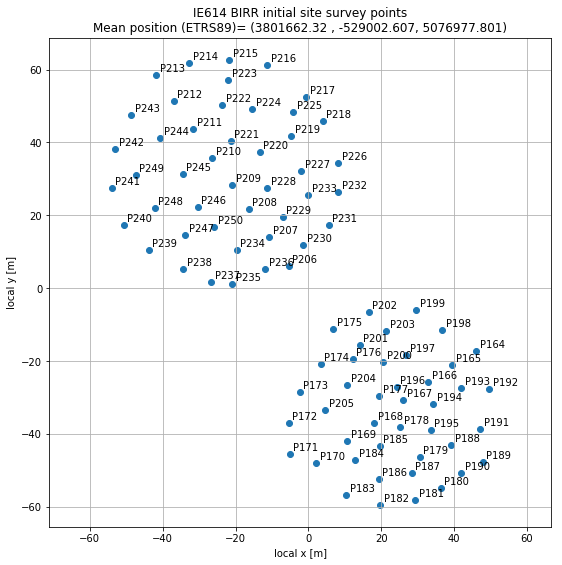

In [13]:
figure(figsize=(9,9))
scatter(local_north_xyz[:,0], local_north_xyz[:,1])
for name, offset in zip(all_names, local_north_xyz):
    text(offset[0]+1, offset[1]+1, name)
axis('equal')
grid()

title('IE614 BIRR initial site survey points\nMean position (ETRS89)= %s' %
      s(mean_position))
xlabel('local x [m]');
ylabel('local y [m]');

The following function interpolates between unstructured points in 3D space.

In [14]:
xyz_interpol_fn = lofargeo.interpolation_function(local_north_xyz)
x_m, y_m = meshgrid(arange(-147, 147), arange(-100, 100))
z_m = xyz_interpol_fn(x_m, y_m)

Now let's plot a map of elevation of the survey points relative to the mean position of all points.

In [15]:
from matplotlib.path import Path
import matplotlib.patches

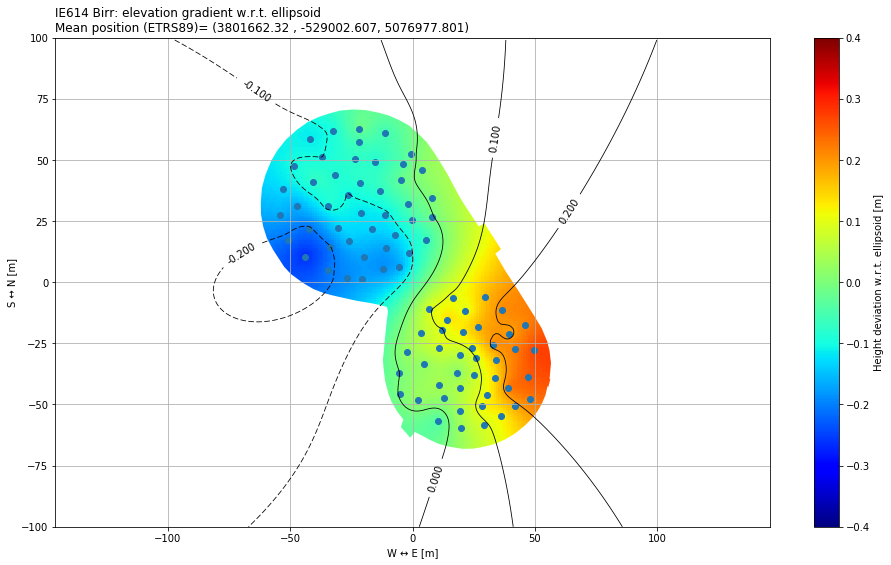

In [16]:
arraybase_path_xyz = Path(append(arraybase_xyz[:,0:2],
                          array([[150,0],[150,110],[-200,110],[-200,-150],
                                 [150,-150],[150,0],arraybase_xyz[-1,0:2]]),
                          axis=0))
maskpatch = matplotlib.patches.PathPatch(arraybase_path_xyz,
                                         facecolor='white', edgecolor='white',
                                         lw=2, zorder=1)

figure(figsize=(16,9))
imshow(z_m, origin='lower', vmin=-.4, vmax=.4, extent=(-147.5, 147.5, -100.5, 100.5),
       cmap='jet')
cb = colorbar()
cb.set_label('Height deviation w.r.t. ellipsoid [m]')

cnt = contour(x_m, y_m, z_m, levels=arange(-2.0, +10.0, 0.10),
              colors='black',
              linewidths=.8)
cnt.clabel(inline=True)
xlabel('W ↔︎ E [m]');
ylabel('S ↔︎ N [m]');
axis('equal')
gca().add_patch(maskpatch)
ylim([-100,100])
xlim([-100,100])
grid()

title('IE614 Birr: elevation gradient w.r.t. ellipsoid\nMean position (ETRS89)= %s' %
      s(mean_position), loc='left')
scatter(local_north_xyz[:,0], local_north_xyz[:,1]);

## Best fit plane and deviations from that plane

In [17]:
solution = lofargeo.fit_plane(spotlevels_etrs)
matrix_pqr_to_etrs = lofargeo.projection_matrix(lofargeo.LOFAR_XYZ0_m, solution['normal'])
print('Normal vector:', solution['normal'])
print('Mean position:', solution['mean'])
print('Rotation matrix PQR to ETRS:\n', matrix_pqr_to_etrs)

Normal vector: [ 0.59434205 -0.08733113  0.79945656]
Mean position: [ 3801662.32038396  -529002.60726935  5076977.80077375]
Rotation matrix PQR to ETRS:
 [[-0.02616099 -0.80378674  0.59434205]
 [ 0.99146077 -0.09684429 -0.08733113]
 [ 0.12775424  0.58698216  0.79945656]]


### CLBA and CHBA from CSV

Read the CLBA and CHBA centers from the CSV.

In [45]:
clba_etrs_given = array([row[1] for row in ecef_rows if "LBA CENTER" in row[2]][0])
chba_etrs_given = array([row[1] for row in ecef_rows if "HBA CENTER" in row[2]][0])

In [48]:
np.savez("centers", clba_etrs_given=clba_etrs_given, chba_etrs_given=chba_etrs_given)

In [19]:
[clba_pqr, chba_pqr] = lofargeo.transform(array([clba_etrs_given,chba_etrs_given]),
                                          solution['mean'],
                                          matrix_pqr_to_etrs.T)

Force the centers to be in the plane in the plane (set *r*-component to 0).

In [20]:
clba_pqr[2]=0
chba_pqr[2]=0
clba_etrs = dot(matrix_pqr_to_etrs, clba_pqr) + solution['mean']
chba_etrs = dot(matrix_pqr_to_etrs, chba_pqr) + solution['mean']

The LBA center and HBA center are put in the plane of the station. The measurement for the centers shows larger elevations than the spot level points, which explains the large difference with non-projected centers. This difference is in the r-direction.

In [21]:
print("Distance between measured CLBA and projected CLBA (meters):",
      norm(clba_etrs_given - clba_etrs))
print("Distance between measured CHBA and projected CHBA (meters):",
      norm(chba_etrs_given - chba_etrs))

Distance between measured CLBA and projected CLBA (meters): 0.359846120406
Distance between measured CHBA and projected CHBA (meters): 0.513988303973


We force the zero of the pqr-system to be at the LBA center.

In [22]:
clba_offset = clba_pqr
clba_pqr = array([0,0,0])
chba_pqr = chba_pqr - clba_offset

## Convert all survey points, plot

In [23]:
station_pqr = lofargeo.transform(spotlevels_etrs,
                                 solution['mean'],
                                 matrix_pqr_to_etrs.T) - clba_offset
station_height_deviation_fn = lofargeo.interpolation_function(station_pqr)
print('p range: ', station_pqr[:,0].min(),'–', station_pqr[:,0].max())
print('q range: ', station_pqr[:,1].min(),'–', station_pqr[:,1].max())

p range:  -30.8521752996 – 59.046992793
q range:  -98.9727275069 – 31.2154102266


In [24]:
[pmin,pmax,qmin,qmax] = [-100, 145, -120, 50]
p_m, q_m = meshgrid(arange(pmin, pmax), arange(qmin, qmax))
r_m = station_height_deviation_fn(p_m, q_m)

Convert the array base to the pqr system, to mask points outside the array base.

In [25]:
arraybase_pqr = lofargeo.transform(arraybase_etrs,
                                   solution['mean'],
                                   matrix_pqr_to_etrs.T) - clba_offset

CLBA_PQR: [0 0 0]
CHBA_PQR: [ 31.06444077 -73.67301996   0.        ]


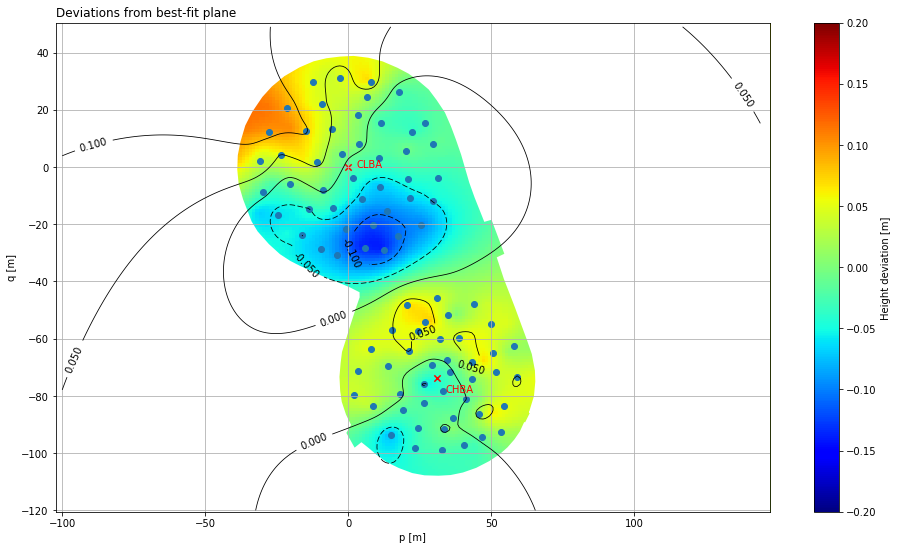

In [40]:
arraybase_path_pqr = Path(append(arraybase_pqr[:,0:2],
                     array([[200,0],[200,100],[-120,100],[-120,-150],
                            [200,-150],[200,0],arraybase_pqr[-1,0:2]]),
                     axis=0))
maskpatch = matplotlib.patches.PathPatch(arraybase_path_pqr, facecolor='white',
                                         edgecolor='white', lw=2, zorder=1)

figure(figsize=(16, 9))
imshow(r_m, origin='lower', extent=(pmin-20, pmax+20, qmin-0.5, qmax+0.5),
       vmin=-.2, vmax=+.2, cmap='jet')
axis('equal')
xlim([pmin,pmax])
grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
cnt = contour(p_m, q_m, r_m, levels=arange(-1.0, +1.0, 0.05), colors='black', linewidths=.8)
cnt.clabel(inline=True)
xlabel('p [m]')
ylabel('q [m]')
scatter(station_pqr[:,0], station_pqr[:,1])

title('''Deviations from best-fit plane''', loc='left')
#title('''Deviations from best-fit plane
#Origin ETRS: %s\nNormal: %s
#CHBA_ETRS = (%.3f, %.3f, %.3f)
#CLBA_ETRS = (%.3f, %.3f, %.3f)''' %
#      (s(solution['mean']), s(solution['normal']),
#       chba_etrs[0], chba_etrs[1], chba_etrs[2],
#       clba_etrs[0], clba_etrs[1], clba_etrs[2]), loc='left')

scatter(chba_pqr[0], chba_pqr[1], color='red', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='red')

scatter(clba_pqr[0], clba_pqr[1], color='red', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='red')

gca().add_patch(maskpatch)

savefig("deviation.pdf")
print("CLBA_PQR:", clba_pqr)
print("CHBA_PQR:", chba_pqr)
savefig("deviations.pdf")

## Reference direction

The reference direction is the northern bisector of the X- and Y- dipoles. At LOFAR core station CS002 LBA, the reference direction coincides with true north, but elsewhere there is a slight deviation to ensure that all dipoles in LOFAR are oriented as similarly as possible. In this section, we determine the deviation between the reference direction (the "q" axis in the pqr system) and geographic north in the ETRS89 reference system.

We will determine the angle between the reference direction of the station (which is (0,1,0) in the pqr system) and ETRS89 north. To do this, we combine the existing conversions from the *local-north* frame to ETRS, and the conversion from ETRS to the pqr system:

In [ ]:
matrix_localnorth_to_pqr = dot(matrix_pqr_to_etrs.T,matrix_localnorth_to_etrs)

To see the q-vector in the *local-north* frame, we apply the inverse conversion (so pqr to *localnorth*) to the vector (0,1,0):

In [ ]:
q_xyz = dot(matrix_localnorth_to_pqr.T,[0,1,0])

Since the reference plane (r=0) makes only a slight angle with the tangent plane to the ellipsoid (z=0), the third component of `q_xyz` is small:

In [ ]:
q_xyz[2]

We can project the q-vector onto the tangent plane to the ellipsoid by setting its last component to 0:

In [ ]:
q_xyz[2] = 0

Now the angle of the q-vector with the north-axis is given by

In [ ]:
deviation_xyz = rad2deg(arctan(q_xyz[0]/q_xyz[1]))

In [ ]:
if deviation_xyz >=0:
    eastorwest = 'east'
else:
    eastorwest = 'west'

To draw a north-arrow in the pqr plane, we use the inverse transformation (so *localnorth* to pqr).

In [ ]:
localnorth_pqr = dot(matrix_localnorth_to_pqr,[0,1,0])
localnorth_pqr[2] = 0 # Project onto to r=0 plane
deviation_pqr = rad2deg(arctan(localnorth_pqr[0]/localnorth_pqr[1]))

Because the reference plane makes only a small angle with the tangent plane to the ellispoid, these numbers are very similar (but with opposite sign):

In [ ]:
-deviation_xyz - deviation_pqr

To represent this graphically:

In [ ]:
fig, (ax_xyz, ax_pqr) = subplots(1,2, figsize=(15,15));
#figure(figsize=(5,5));

for ax in [ax_xyz, ax_pqr]:
  ax.set_aspect('equal', adjustable='box')
  ax.set_xlim([-1.0,1.5]);
  ax.set_ylim([-0.1,1.5]);
  ax.axis('off')

ax_xyz.arrow(0, 0, q_xyz[0], q_xyz[1], head_width=0.1, head_length=0.1,
             fc='b', ec='b');
ax_xyz.text(          q_xyz[0], q_xyz[1], 'Reference direction   \n(q-axis)     ', ha='right', va='bottom')
ax_xyz.arrow(0, 0, 0, 1.2, head_width=0.1, head_length=0.1, fc='k', ec='k');
ax_xyz.text(          0, 1.2, '   North');
ax_xyz.arrow(0, 0, 1.2, 0, head_width=0.1, head_length=0.1, fc='k', ec='k');
ax_xyz.text(          1.2, 0, '     East', va='bottom');
ax_xyz.set_title("First estimate of reference direction (q-axis) for\nIE614 Birr is\
 %.4f degrees %s from north."%(abs(deviation_xyz), eastorwest), loc='left');

ax_pqr.arrow(0, 0, localnorth_pqr[0], localnorth_pqr[1], head_width=0.1, head_length=0.1,
             fc='b', ec='b');
ax_pqr.text(       localnorth_pqr[0], localnorth_pqr[1], '   Local north', ha='left')
ax_pqr.arrow(0, 0, 0, 1.2, head_width=0.1, head_length=0.1, fc='k', ec='k');
ax_pqr.text(          0, 1.2, '   q (reference direction)');
ax_pqr.arrow(0, 0, 1.2, 0, head_width=0.1, head_length=0.1, fc='k', ec='k');
ax_pqr.text(          1.2, 0, '     p', va='bottom');
ax_pqr.set_title("First estimate of localnorth in pqr for\nIE614 Birr is\
 %.4f degrees from q-axis."%(deviation_pqr), loc='left');

## Export array base as CSV

In [ ]:
arraybase_pqr = lofargeo.transform(arraybase_etrs,
                                   solution['mean'],
                                   matrix_pqr_to_etrs.T) - clba_offset

In [ ]:
ptsandnames = np.zeros(len(arraybase_pqr)+2, dtype=[('name', '<U4'), ('p', float), ('q', float), ('r', float)])
ptsandnames['name']=array(arraybase_pointnrs+['CLBA','CHBA'])
ptsandnames['p']=append(arraybase_pqr[:,0],[clba_pqr[0],chba_pqr[0]])
ptsandnames['q']=append(arraybase_pqr[:,1],[clba_pqr[1],chba_pqr[1]])
ptsandnames['r']=append(arraybase_pqr[:,2],[clba_pqr[2],chba_pqr[2]])

In [ ]:
scatter(arraybase_pqr[:,0],arraybase_pqr[:,1])
scatter([clba_pqr[0]],[clba_pqr[1]])
scatter([chba_pqr[0]],[chba_pqr[1]])
axis('equal')
xlabel('p (m)');
ylabel('q (m)');

In [ ]:
savetxt("ie614-initialsurvey-arraybase-pqr.csv",
        ptsandnames,
        delimiter=",", header='pointnr,p,q,r', comments='', fmt='%s %.6f %.6f %.6f')

## Station rotation

The rotation of this station (in the pqr-system) has been decided to be 84 degrees.

## Container coordinates back to ETRS

In [42]:
container_pqr=array([
        [49.7944,-26.5911,0],
        [49.3121,-30.6724,0],
        [52.6431,-29.6246,0],
        [46.932,-23.6406,0],
        [50.2533,-22.5372,0]]) # Given in PQ Coordinates IE-613 LBA HBA Container V1.xls , 17/03/2017 

In [43]:
container_etrs = lofargeo.transform(container_pqr,zeros(3),matrix_pqr_to_etrs)+clba_etrs

In [44]:
container_etrs

array([[ 3801653.89903291,  -528970.31711494,  5076987.58879604],
       [ 3801657.19214519,  -528970.40004585,  5076985.13152988],
       [ 3801656.26279517,  -528967.19896348,  5076986.17211916],
       [ 3801651.60234336,  -528973.44081133,  5076988.95500317],
       [ 3801650.62855656,  -528970.25473068,  5076990.02698944]])

## Read in PQ Coordinates IE-613 LBA HBA Container V1

In [64]:
with open('PQ Coordinates IE-613 LBA HBA Container V1.csv', 'r') as csv_file:
    pqr_v1 = {}
    reader = csv.reader(csv_file, delimiter=';')
    next(reader) # Skip header
    for row in csv.reader(csv_file, delimiter=';'):
        pqr_v1[row[0]]=array([float(num) for num in row[1:]])
print(len(pqr_v1))

698


In [116]:
pqr_v1_sorted_dict=dict();
pqr_v1_sorted_dict["LBA Cable exit marker"]=array([pqr_v1[k][0:2] for k in pqr_v1.keys() if k[0:2]=='11']);
pqr_v1_sorted_dict["LBA Marker 2 ('piketten boven')"]=array([pqr_v1[k][0:2] for k in pqr_v1.keys() if k[0:2]=='12']);
pqr_v1_sorted_dict["LBA Marker 3 ('piketten beneden')"]=array([pqr_v1[k][0:2] for k in pqr_v1.keys() if k[0:2]=='13']);
pqr_v1_sorted_dict["Hulppiketten graven LBA veld"]=array([pqr_v1[k][0:2] for k in pqr_v1.keys() if k[0:3]=='LBD']);

# PQR coordinates for HBA are given relative to HBA center, correct that here
pqr_v1_sorted_dict["HBA Cable entrance points"] = array([(chba_pqr+pqr_v1[k])[0:2] for k in pqr_v1.keys() if k[0:2]=='20']);
pqr_v1_sorted_dict["HBA Marker points"] = array([(chba_pqr+pqr_v1[k])[0:2] for k in pqr_v1.keys() if k[0:2]=='21' or k[0:2]=='22']);
pqr_v1_sorted_dict["Hulppiketten graven HBA veld"] = array([(chba_pqr+pqr_v1[k])[0:2] for k in pqr_v1.keys() if k[0:3]=='HBD']);

pqr_v1_sorted_dict["Container"]=array([pqr_v1[k][0:2] for k in pqr_v1.keys() if k[0]=='C']);

sum([len(lst[1]) for lst in pqr_v1_sorted_dict.items()])

698

In [139]:
# Reorder container points so that contours are drawn:
containerpts = pqr_v1_sorted_dict["Container"][[1,2,4,3,1],:]

In [137]:
colors=dict();
colors["LBA Cable exit marker"] = "black";
colors["HBA Cable entrance points"] = "black";
colors["Hulppiketten graven HBA veld"] = "lightgray";
colors["Hulppiketten graven LBA veld"] = "lightgray";
colors["LBA Marker 2 ('piketten boven')"] = "red";
colors["LBA Marker 3 ('piketten beneden')"] = "green";
colors["HBA Marker points"] = "blue";

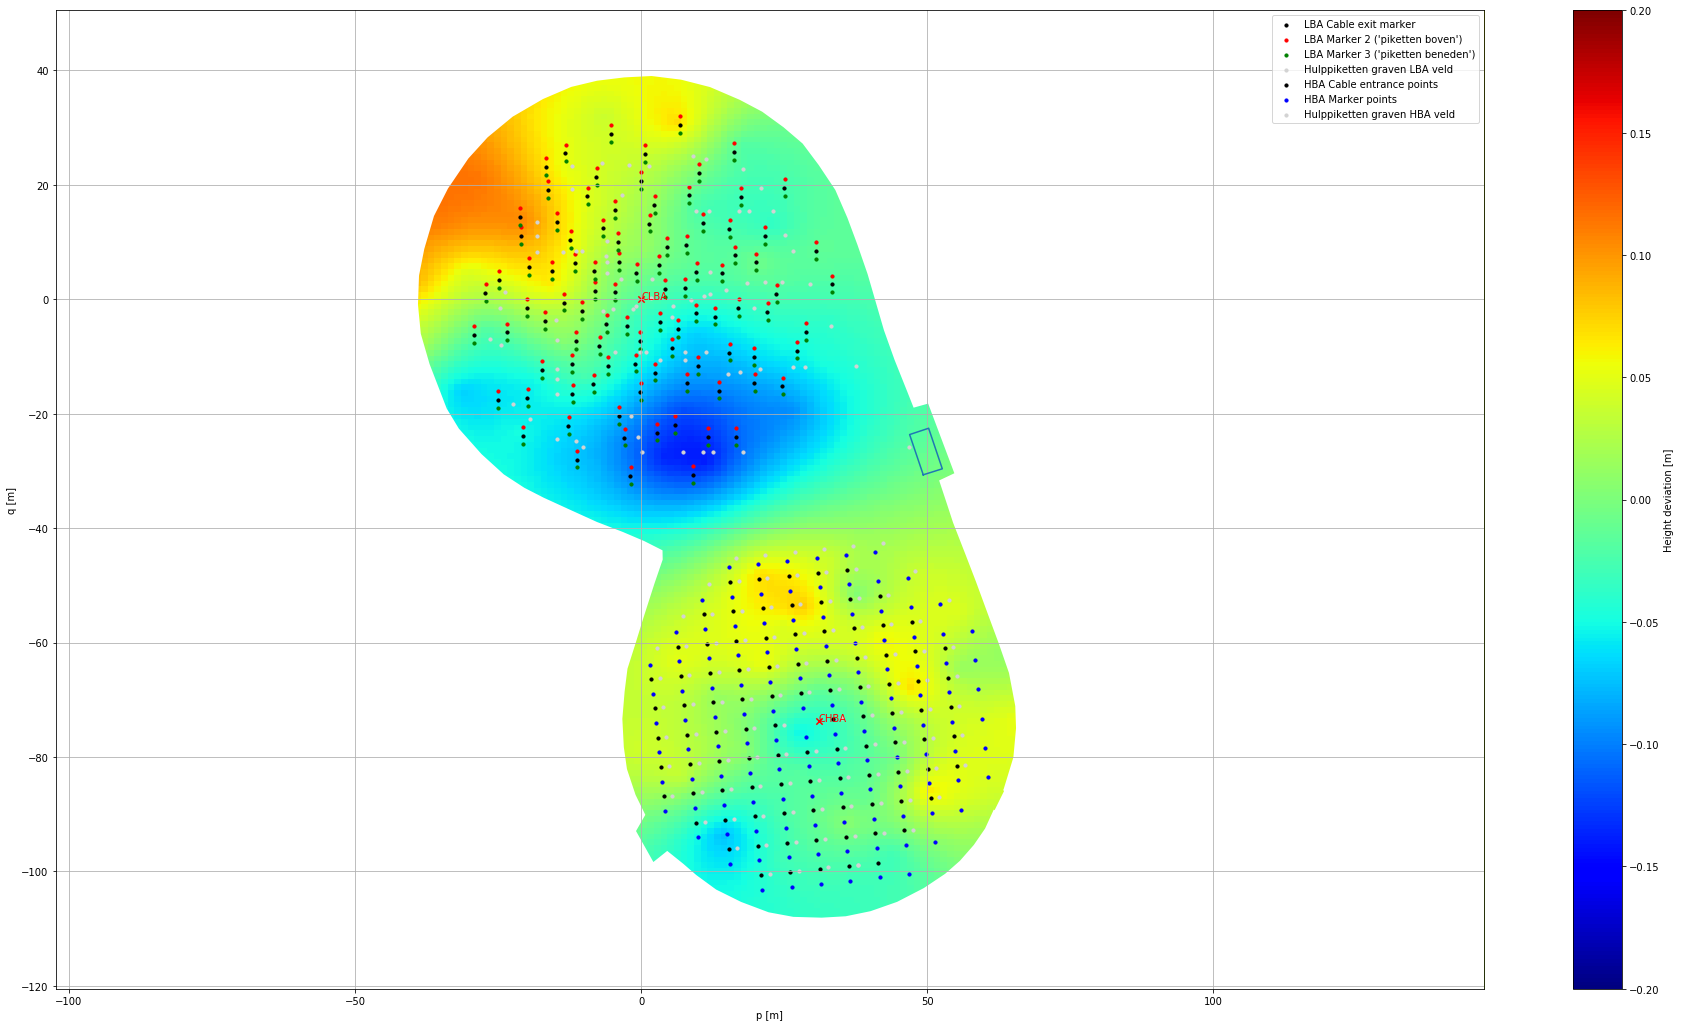

In [141]:
arraybase_path_pqr = Path(append(arraybase_pqr[:,0:2],
                     array([[200,0],[200,100],[-120,100],[-120,-150],
                            [200,-150],[200,0],arraybase_pqr[-1,0:2]]),
                     axis=0))
maskpatch = matplotlib.patches.PathPatch(arraybase_path_pqr, facecolor='white',
                                         edgecolor='white', lw=2, zorder=1)

figure(figsize=(2*16, 2*9))
imshow(r_m, origin='lower', extent=(pmin-20, pmax+20, qmin-0.5, qmax+0.5),
       vmin=-.2, vmax=+.2, cmap='jet')
axis('equal')
xlim([pmin,pmax])
grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
#cnt = contour(p_m, q_m, r_m, levels=arange(-1.0, +1.0, 0.05), colors='black', linewidths=.8)
#cnt.clabel(inline=True)
xlabel('p [m]')
ylabel('q [m]')

for markertype in pqr_v1_sorted_dict:
    if markertype == "Container":
        continue
    else:
        scatter(pqr_v1_sorted_dict[markertype][:,0], pqr_v1_sorted_dict[markertype][:,1],
                s=10, color=colors[markertype], label=markertype)

plot(containerpts[:,0], containerpts[:,1])        
        
legend()
        
scatter(chba_pqr[0], chba_pqr[1], color='red', s=40, marker='x')
text(chba_pqr[0], chba_pqr[1], 'CHBA', color='red')

scatter(clba_pqr[0], clba_pqr[1], color='red', s=40, marker='x')
text(clba_pqr[0], clba_pqr[1], 'CLBA', color='red')
    
gca().add_patch(maskpatch);

savefig("markers_v1.pdf")